In [7]:
%load_ext autoreload
%autoreload 2
import os
import sys
from  partie1 import GRUEncoderGD, GRUDecoderGD
from  partie1 import GRUEncoderDG, GRUDecoderDG
from  partie1 import BiGRUEncoder, BiGRUDecoder
from partie1 import LSTMEncoder, LSTMDecoder
from partie1 import TensorProductEncoder

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
##### entiers 0-10 
def generate_data(batch_size, seq_len, min_val=0, max_val=10):
    return torch.randint(min_val, max_val, (batch_size, seq_len))

def precision(predicted, target):
    correct = (predicted.argmax(dim=-1) == target).float()
    return correct.mean().item() * 100

# Gauche droite

## **GRU**

### TRAIN

Epoch [10/50000], Loss: 2.3063, Accuracy: 11.87%
Epoch [20/50000], Loss: 2.3163, Accuracy: 8.12%
Epoch [30/50000], Loss: 2.3110, Accuracy: 8.12%
Epoch [40/50000], Loss: 2.3070, Accuracy: 8.12%
Epoch [50/50000], Loss: 2.3015, Accuracy: 11.87%
Epoch [60/50000], Loss: 2.3035, Accuracy: 6.88%
Epoch [70/50000], Loss: 2.2999, Accuracy: 12.50%
Epoch [80/50000], Loss: 2.3089, Accuracy: 5.62%
Epoch [90/50000], Loss: 2.3034, Accuracy: 10.00%
Epoch [100/50000], Loss: 2.3032, Accuracy: 10.63%
Epoch [110/50000], Loss: 2.3026, Accuracy: 6.88%
Epoch [120/50000], Loss: 2.3030, Accuracy: 12.50%
Epoch [130/50000], Loss: 2.3007, Accuracy: 10.00%
Epoch [140/50000], Loss: 2.3025, Accuracy: 15.62%
Epoch [150/50000], Loss: 2.2959, Accuracy: 16.25%
Epoch [160/50000], Loss: 2.2870, Accuracy: 10.00%
Epoch [170/50000], Loss: 2.2661, Accuracy: 9.38%
Epoch [180/50000], Loss: 2.2695, Accuracy: 10.63%
Epoch [190/50000], Loss: 2.2707, Accuracy: 11.87%
Epoch [200/50000], Loss: 2.2519, Accuracy: 18.75%
Epoch [210/50000

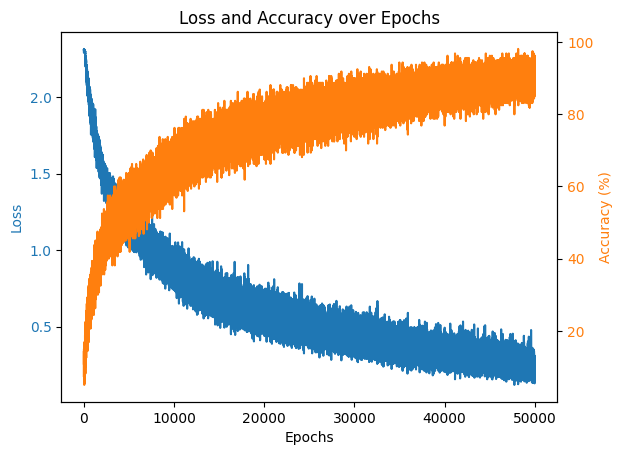

In [8]:

input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 16
seq_len = 10
epochs = 50000
learning_rate = 0.001

encoder = GRUEncoderGD(input_size, emb_size, hidden_size)
decoder = GRUDecoderGD(emb_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapt√© pour des classes discr√®tes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []

for epoch in range(epochs):
    x = generate_data(batch_size, seq_len)
    target = x.clone()

    hidden = encoder(x)
    reconstructed_x = decoder(hidden, seq_len)

    loss = criterion(reconstructed_x.view(-1, output_size), target.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, target)
    losses.append(loss.item())
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")



torch.save(encoder, "./models/GD/gru_enc.pth")
torch.save(decoder, "./models/GD/gru_dec.pth")


fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)', color='tab:orange')  
ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title('Loss and Accuracy over Epochs')

plt.savefig(f"./resultats/GD/training_gru_{epochs}_epochs.png")
plt.show()

### EVAL

In [13]:
encoder = torch.load("./models/GD/gru_enc.pth")
decoder = torch.load("./models/GD/gru_dec.pth")

encoder.eval()
decoder.eval()

n_iter = 5000
accuracies = []
for _ in range(n_iter):
    x = generate_data(batch_size, seq_len)
    # print(x)
    # target = x.clone()

    hidden = encoder(x)
    reconstructed_x = decoder(hidden, seq_len)

    accuracy = precision(reconstructed_x, x)

    accuracies.append(accuracy)


plt.plot(accuracies)
print(np.array(accuracies).mean())

/tmp/ipykernel_15661/3588273814.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/GD/gru_enc.pth")
/tmp/ipykernel_15661/3588273814.py:2: Fut

93.03412504911422


## **LSTM**

### TRAIN

In [15]:
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 16
seq_len = 10
epochs = 50000
learning_rate = 0.001

encoder = LSTMEncoder(input_size, emb_size, hidden_size)
decoder = LSTMDecoder(emb_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapt√© pour des classes discr√®tes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []
for epoch in range(epochs):
    x = generate_data(batch_size, seq_len)
    target = x.clone()

    hidden = encoder(x)
    reconstructed_x = decoder(hidden, seq_len)

    loss = criterion(reconstructed_x.view(-1, output_size), target.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, target)
    losses.append(loss.item())
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")


torch.save(encoder, "./models/GD/lstm_enc.pth")

torch.save(decoder, "./models/GD/lstm_dec.pth")


fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)', color='tab:orange')  
ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')


fig.tight_layout()  
plt.title('Loss and Accuracy over Epochs')

plt.savefig(f"./resultats/training_lstm_{epochs}_epochs.png")
plt.show()



Epoch [10/50000], Loss: 2.3066, Accuracy: 8.12%
Epoch [20/50000], Loss: 2.3022, Accuracy: 8.75%
Epoch [30/50000], Loss: 2.3021, Accuracy: 10.63%
Epoch [40/50000], Loss: 2.3056, Accuracy: 8.75%
Epoch [50/50000], Loss: 2.3033, Accuracy: 11.25%
Epoch [60/50000], Loss: 2.3064, Accuracy: 8.75%
Epoch [70/50000], Loss: 2.3015, Accuracy: 11.87%
Epoch [80/50000], Loss: 2.3045, Accuracy: 7.50%
Epoch [90/50000], Loss: 2.3000, Accuracy: 13.12%
Epoch [100/50000], Loss: 2.3052, Accuracy: 8.12%
Epoch [110/50000], Loss: 2.3017, Accuracy: 12.50%
Epoch [120/50000], Loss: 2.3012, Accuracy: 11.87%
Epoch [130/50000], Loss: 2.3082, Accuracy: 5.62%
Epoch [140/50000], Loss: 2.2992, Accuracy: 11.25%
Epoch [150/50000], Loss: 2.3027, Accuracy: 10.63%
Epoch [160/50000], Loss: 2.2926, Accuracy: 13.75%
Epoch [170/50000], Loss: 2.2755, Accuracy: 18.13%
Epoch [180/50000], Loss: 2.2673, Accuracy: 14.37%
Epoch [190/50000], Loss: 2.2705, Accuracy: 11.25%
Epoch [200/50000], Loss: 2.2671, Accuracy: 15.00%
Epoch [210/50000

### EVAL

/tmp/ipykernel_4847/1528415794.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/lstm_enc.pth")
/tmp/ipykernel_4847/1528415794.py:2: FutureW

93.14937499523163


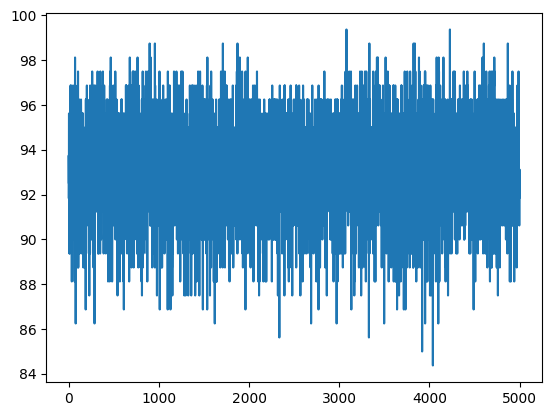

In [23]:
encoder = torch.load("./models/lstm_enc.pth")
decoder = torch.load("./models/lstm_dec.pth")

encoder.eval()
decoder.eval()

n_iter = 5000
accuracies = []
for _ in range(n_iter):
    x = generate_data(batch_size, seq_len)
    # print(x)
    # target = x.clone()

    hidden = encoder(x)
    reconstructed_x = decoder(hidden, seq_len)

    accuracy = precision(reconstructed_x, x)

    accuracies.append(accuracy)


plt.plot(accuracies)
print(np.array(accuracies).mean())

## **TPDN**

### TRAIN

/tmp/ipykernel_2032505/982479531.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/GD/gru_enc.pth")


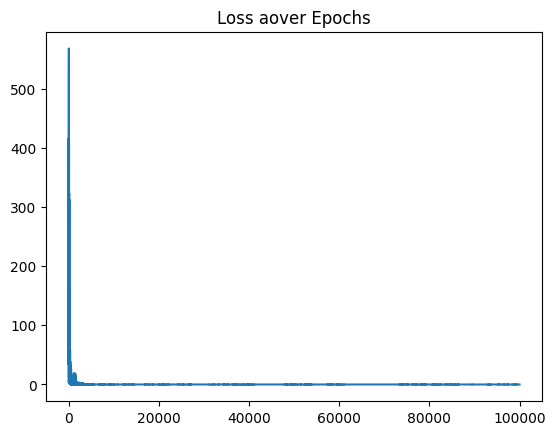

In [9]:
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 1
seq_len = 10
epochs = 100000
learning_rate = 0.01
seq_len_tensor = torch.tensor([seq_len])


encoder = torch.load("./models/GD/gru_enc.pth")
tpdnencoder = TensorProductEncoder(n_roles=seq_len, n_fillers=seq_len, filler_dim=hidden_size, role_dim=hidden_size, hidden_size=hidden_size)

def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # r√¥les
    return data, roles

criterion = nn.MSELoss()
optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)

encoder.eval()
tpdnencoder.train()
losses = []
for epoch in range(epochs):

    data, roles = generate_data(batch_size, seq_len, input_size)

    encoder_output = encoder(data).squeeze(0)  
    tpdn_output = tpdnencoder(data, roles)
    # reconstructed_x = decoder(tpdn_output.unsqueeze(0), seq_len_tensor)
    loss = criterion(encoder_output, tpdn_output)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.save(tpdnencoder, "./models/GD/tpdn_gru.pth")


plt.plot(losses)
plt.title('Loss aover Epochs')
plt.show()



In [5]:
def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))


    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')

    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
encoder = torch.load("./models/GD/gru_enc.pth")
tpdnencoder = torch.load("./models/GD/tpdn_gru.pth")
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 1
seq_len = 10
epochs = 10000
learning_rate = 0.01
seq_len_tensor = torch.tensor([seq_len])
criterion = nn.MSELoss()

def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # r√¥les
    return data, roles

data2, roles2 = generate_data(batch_size, seq_len, input_size)
encoder_output2 = encoder(data2).squeeze(0)  
tpdn_output2 = tpdnencoder(data2, roles2) 
loss = criterion(encoder_output2, tpdn_output2)
print(data2)
plot_tensors(encoder_output2, tpdn_output2, labels = ("encodeur_output","tpdn_ouput"))
print(loss)


tensor([[7, 9, 5, 0, 7, 6, 0, 4, 0, 9]])


tensor(0.0180, grad_fn=<MseLossBackward0>)


In [16]:
encoder = torch.load('./models/GD/gru_enc.pth')
tpdnencoder = torch.load('./models/GD/tpdn_gru.pth')
decoder = torch.load("./models/GD/gru_dec.pth")

encoder.eval()
tpdnencoder.eval()
decoder.eval()

### TEST
precisionsgru = []
precisionstpdn = []
for _ in range(100):
    data, roles = generate_data(batch_size, seq_len, input_size)

    encoder_output = encoder(data)  # (seq_len, batch_size, hidden_size)
    tpdn_output = tpdnencoder(data, roles)  # (batch_size, hidden_size)
    loss = criterion(encoder_output, tpdn_output)

    seq_len_tensor = torch.tensor([seq_len])


    reconstructed_tpdn = decoder(tpdn_output.unsqueeze(0), seq_len_tensor).argmax(dim=1)
    reconstructed_gru = decoder(encoder_output, seq_len_tensor).argmax(dim=1)
    print()
    print( "DATA : " ,data)
    print("GRU : ", reconstructed_gru)
    print( "TPDN : ", reconstructed_tpdn)
    print()
    precisionsgru.append(precision(reconstructed_gru, data))
    precisionstpdn.append(precision(reconstructed_tpdn, data))

print( np.array(precisionsgru).mean())
print( np.array(precisionstpdn).mean())

/tmp/ipykernel_2032505/1120392934.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('./models/GD/gru_enc.pth')
/tmp/ipykernel_2032505/1120392934.py:2:


DATA :  tensor([[0, 0, 3, 0, 9, 8, 7, 8, 7, 6]])
GRU :  tensor([[0, 3, 4, 2, 4, 4, 9, 8, 7, 4]])
TPDN :  tensor([[0, 2, 4, 7, 5, 5, 9, 6, 4, 5]])


DATA :  tensor([[8, 1, 2, 6, 2, 6, 7, 1, 7, 4]])
GRU :  tensor([[1, 7, 4, 8, 9, 9, 5, 6, 2, 0]])
TPDN :  tensor([[1, 7, 0, 8, 9, 9, 3, 6, 2, 5]])


DATA :  tensor([[8, 5, 3, 6, 1, 8, 6, 7, 4, 1]])
GRU :  tensor([[4, 9, 9, 2, 8, 1, 3, 7, 0, 3]])
TPDN :  tensor([[4, 9, 8, 3, 1, 8, 6, 6, 0, 5]])


DATA :  tensor([[2, 6, 5, 4, 5, 6, 0, 8, 0, 0]])
GRU :  tensor([[9, 6, 0, 7, 3, 2, 5, 5, 7, 5]])
TPDN :  tensor([[8, 2, 0, 5, 3, 4, 5, 5, 9, 5]])


DATA :  tensor([[4, 0, 7, 3, 1, 0, 2, 9, 5, 0]])
GRU :  tensor([[9, 4, 6, 3, 0, 8, 7, 2, 6, 7]])
TPDN :  tensor([[9, 5, 6, 4, 0, 0, 7, 2, 1, 7]])


DATA :  tensor([[8, 2, 2, 7, 9, 0, 8, 4, 3, 4]])
GRU :  tensor([[5, 4, 0, 8, 9, 7, 8, 3, 6, 4]])
TPDN :  tensor([[4, 7, 7, 2, 9, 7, 8, 3, 5, 6]])


DATA :  tensor([[2, 9, 0, 7, 6, 1, 1, 8, 7, 5]])
GRU :  tensor([[2, 5, 1, 8, 9, 9, 4, 3, 7, 0]])
TPDN :  tensor

In [1]:
import torch
import torch.nn as nn
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter

# Charger les mod√®les
encoder = torch.load("./models/GD/gru_enc.pth")
tpdnencoder = torch.load("./models/GD/tpdn_gru.pth")

# Param√®tres
input_size = 10
seq_len = 10
batch_size = 1
emb_size = 16
hidden_size = 32
output_size = 10

criterion = nn.MSELoss()

# Fonction pour g√©n√©rer des donn√©es factices
def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # r√¥les
    return data, roles

# G√©n√©ration de donn√©es factices
data2, roles2 = generate_data(batch_size, seq_len, input_size)

# Passage des donn√©es dans les mod√®les
encoder_output2 = encoder(data2).squeeze(0)
tpdn_output2 = tpdnencoder(data2, roles2)

# Calcul de la perte
loss = criterion(encoder_output2, tpdn_output2)

# üìå **Visualisation avec torchviz**
dot = make_dot(encoder_output2, params=dict(encoder.named_parameters()))
dot.render("encoder_graph", format="png")

dot_tpdn = make_dot(tpdn_output2, params=dict(tpdnencoder.named_parameters()))
dot_tpdn.render("tpdn_graph", format="png")

# üìå **Visualisation avec TensorBoard**
writer = SummaryWriter("logs")
writer.add_graph(encoder, data2)
writer.add_graph(tpdnencoder, (data2, roles2))
writer.close()

# Affichage des r√©sultats
print("Data Input:", data2)
print("Loss:", loss.item())

print("üöÄ Ouvrir TensorBoard avec la commande : tensorboard --logdir=logs")


2025-02-07 18:40:25.225120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Input: tensor([[7, 7, 3, 2, 3, 7, 8, 0, 1, 3]])
Loss: 0.03330567479133606
üöÄ Ouvrir TensorBoard avec la commande : tensorboard --logdir=logs


# Droite gauche 

## **GRU**

### TRAIN

In [ ]:

input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 16
seq_len = 10
epochs = 50000
learning_rate = 0.001

encoder = GRUEncoderDG(input_size, emb_size, hidden_size)
decoder = GRUDecoderDG(emb_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapt√© pour des classes discr√®tes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []

for epoch in range(epochs):
    x = generate_data(batch_size, seq_len)
    target = x.clone()

    hidden = encoder(x)
    reconstructed_x = decoder(hidden, seq_len)

    loss = criterion(reconstructed_x.view(-1, output_size), target.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, target)
    losses.append(loss.item())
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")



torch.save(encoder, "./models/DG/gru_enc.pth")
torch.save(decoder, "./models/DG/gru_dec.pth")


fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(range(epochs), losses, label='Loss')


ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)')  
ax2.plot(range(epochs), accuracies, label='Accuracy')

plt.title('Loss and Accuracy over Epochs')

plt.savefig(f"./resultats/DG/training_gru_{epochs}_epochs.png")
plt.show()

## **TPDN**

### TRAIN

In [26]:
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 1
seq_len = 10
epochs = 100000
learning_rate = 0.01
seq_len_tensor = torch.tensor([seq_len])


encoder = torch.load("./models/DG/gru_enc.pth")
tpdnencoder = TensorProductEncoder(n_roles=seq_len, n_fillers=seq_len, filler_dim=hidden_size, role_dim=hidden_size, hidden_size=hidden_size)

def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # r√¥les
    return data, roles

criterion = nn.MSELoss()
optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)

encoder.eval()
tpdnencoder.train()
losses = []
for epoch in range(epochs):

    data, roles = generate_data(batch_size, seq_len, input_size)
    roles = torch.flip(roles, dims=[1])

    encoder_output = encoder(data).squeeze(0)  
    tpdn_output = tpdnencoder(data, roles)
    # reconstructed_x = decoder(tpdn_output.unsqueeze(0), seq_len_tensor)
    loss = criterion(encoder_output, tpdn_output)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.save(tpdnencoder, "./models/DG/tpdn_gru.pth")


plt.plot(losses)
plt.title('Loss aover Epochs')
plt.show()


/tmp/ipykernel_15661/2166836414.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/DG/gru_enc.pth")


# Bi directionel 

## **GRU**

### TRAIN

In [ ]:

input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 16
seq_len = 10
epochs = 50000
learning_rate = 0.001

encoder = BiGRUEncoder(input_size, emb_size, hidden_size)
decoder = BiGRUDecoder(emb_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapt√© pour des classes discr√®tes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []

for epoch in range(epochs):
    x = generate_data(batch_size, seq_len)
    target = x.clone()

    hidden = encoder(x)
    reconstructed_x = decoder(hidden, seq_len)

    loss = criterion(reconstructed_x.view(-1, output_size), target.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, target)
    losses.append(loss.item())
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")



torch.save(encoder, "./models/BI/gru_enc.pth")
torch.save(decoder, "./models/BI/gru_dec.pth")


fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)', color='tab:orange')  
ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title('Loss and Accuracy over Epochs')

plt.savefig(f"./resultats/BI/training_gru_{epochs}_epochs.png")
plt.show()

## **TPDN** 

### TRAIN

In [4]:


encoder = torch.load("./models/BI/gru_enc.pth")
encoder.eval()  

input_size = 10
hidden_size = 32
batch_size = 1
seq_len = 10
epochs = 100000
learning_rate = 0.01


tpdnencoder = TensorProductEncoder(
    n_roles=seq_len, 
    n_fillers=input_size,  
    filler_dim=2*hidden_size, 
    role_dim=2*hidden_size, 
    hidden_size=2*hidden_size
)


def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # Fillers (tokens)
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # R√¥les (positions)
    return data, roles


criterion = nn.MSELoss()
optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20000, gamma=0.5)  


tpdnencoder.train()

losses = []

for epoch in range(epochs):

    data, roles = generate_data(batch_size, seq_len, input_size)
    roles = torch.cat([roles, torch.flip(roles, dims=[1])], dim=1)  # √âtendre les r√¥les
    data = torch.cat([data, data], dim=1)  


    with torch.no_grad():
        encoder_output = encoder(data).squeeze(0) 
    tpdn_output = tpdnencoder(data, roles) 

    # print( encoder_output.shape)
    # print( tpdn_output.shape)

    loss = criterion(tpdn_output, encoder_output.detach())  
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()  


    if epoch % 1000 == 0:
        print(f"√âpoque {epoch}/{epochs} - Loss: {loss.item():.6f}")


torch.save(tpdnencoder, "./models/BI/tpdn_gru.pth")

plt.plot(losses)
plt.title('Loss over Epochs')
plt.xlabel('√âpoque')
plt.ylabel('Loss')
plt.show()


/tmp/ipykernel_2032505/3291806127.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load("./models/BI/gru_enc.pth")


√âpoque 0/100000 - Loss: 9.441168
√âpoque 1000/100000 - Loss: 26.046669
√âpoque 2000/100000 - Loss: 2.822055
√âpoque 3000/100000 - Loss: 3.103365
√âpoque 4000/100000 - Loss: 0.997902
√âpoque 5000/100000 - Loss: 0.754057
√âpoque 6000/100000 - Loss: 0.196245
√âpoque 7000/100000 - Loss: 0.152641
√âpoque 8000/100000 - Loss: 0.074532
√âpoque 9000/100000 - Loss: 0.093470
√âpoque 10000/100000 - Loss: 0.055887
√âpoque 11000/100000 - Loss: 0.073962
√âpoque 12000/100000 - Loss: 0.101811
√âpoque 13000/100000 - Loss: 9.911036
√âpoque 14000/100000 - Loss: 0.170867
√âpoque 15000/100000 - Loss: 0.073997
√âpoque 16000/100000 - Loss: 0.059318
√âpoque 17000/100000 - Loss: 0.090116
√âpoque 18000/100000 - Loss: 0.134278
√âpoque 19000/100000 - Loss: 0.124027
√âpoque 20000/100000 - Loss: 0.152803
√âpoque 21000/100000 - Loss: 0.068483
√âpoque 22000/100000 - Loss: 0.098943
√âpoque 23000/100000 - Loss: 0.064348
√âpoque 24000/100000 - Loss: 0.082438
√âpoque 25000/100000 - Loss: 0.039569
√âpoque 26000/100000 - L